In [1]:
import numpy as np
import librosa
import os
from scipy import signal
from audiomentations import Compose, HighShelfFilter, LowShelfFilter, AddGaussianNoise
from pedalboard import *
import matplotlib.pyplot as plt
import pygame
from ipywidgets import Button, Output, HBox, VBox

pygame 2.5.2 (SDL 2.28.3, Python 3.9.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import tensorflow_hub as hub

yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

2024-05-10 22:14:13.373534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 22:14:20.310802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
def load_audio_file(file_path):
    # Load the audio file and convert the sampling rate
    wave, sr = librosa.load(file_path, sr=16000, mono=True)
    return wave


def extract_features(audio):
    # YAMNet returns three outputs: scores, embeddings, spectrogram
    scores, embeddings, spectrogram = yamnet(audio)
    # Truncate or pad the embeddings as needed to fit the model input
    max_time_steps = 60  # Assume maximum time steps
    if embeddings.shape[0] < max_time_steps:
        # Padding
        embeddings = np.pad(embeddings, ((0, max_time_steps - embeddings.shape[0]), (0, 0)), 'constant')
    elif embeddings.shape[0] > max_time_steps:
        # Truncating
        embeddings = embeddings[:max_time_steps]
    return embeddings

In [8]:
# augmentation

def pitch_shift(audio, sample_rate=22050, pitch_shift_steps=2):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=pitch_shift_steps)


def add_bgn(audio, sample_rate=22050):
    noise = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)])
    return noise(audio, sample_rate)


def reverb(audio):
    board = Pedalboard([Chorus(), Reverb(room_size=0.25)])
    return board(audio, 22050)


# filters for augmentation
def butterworth(audio):
    b, a = signal.butter(4, 1/16, 'low', analog=False)
    return signal.filtfilt(b, a, audio)


def chev1(audio):
    b, a = signal.cheby1(4, 5, 1/16, 'low', analog=False)
    return signal.filtfilt(b, a, audio)


def chev2(audio):
    b, a = signal.cheby2(4, 50, 1/16, 'low', analog=False)
    return signal.filtfilt(b, a, audio)


def ellip(audio):
    b, a = signal.ellip(4, 5, 50, 1/16, 'low', analog=False)
    return signal.filtfilt(b, a, audio)


def ellipH(audio):
    b, a = signal.ellip(4, 5, 50, 1/16, 'high', analog=False)
    return signal.filtfilt(b, a, audio)


def ellipB(audio):
    b, a = signal.ellip(4, 5, 50, [1/32, 1/16], 'band', analog=False)
    return signal.filtfilt(b, a, audio)


def peak(audio):
    b, a = signal.iirpeak(200, 30, 16000)
    return signal.filtfilt(b, a, audio)


def highshelf(audio):
    noise = Compose([HighShelfFilter(min_center_freq=100, max_center_freq=1000, p=0.5)])
    return noise(audio, 16000)


def lowshelf(audio):
    noise = Compose([LowShelfFilter(min_center_freq=100, max_center_freq=1000, p=0.5)])
    return noise(audio, 16000)

In [21]:
import os
import numpy as np

def process_folder(folder_path):
    all_embeddings = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.mp3'):  
            file_path = os.path.join(folder_path, filename)
            audio_original = load_audio_file(file_path)
            # audio0 = pitch_shift(audio_original)
            # audio1 = add_bgn(audio_original)
            # audio2 = reverb(audio_original)
            # audio3 = lowshelf(audio_original)

            embeddings_ori = extract_features(audio_original)
            # embeddings0 = extract_features(audio0)
            # embeddings1 = extract_features(audio1)
            # embeddings2 = extract_features(audio2)
            # embeddings3 = extract_features(audio3)

            all_embeddings[filename] = embeddings_ori 
            # all_embeddings[filename + '0aug'] = embeddings0
            # all_embeddings[filename + '1aug'] = embeddings1
            # all_embeddings[filename + '2aug'] = embeddings2
            # all_embeddings[filename + '3aug'] = embeddings3

    return all_embeddings


folder_path = '/Users/apple/Documents/DST/Final_project/Filters-Implementation-in-Data-Augmentation/PMEmo2019/chorus'
embeddings_dict = process_folder(folder_path)

In [ ]:
# import IPython
# IPython.display.Audio()

In [22]:
# print all keys
# print(list(embeddings_dict.keys()))

In [23]:
# 创建一个新字典，其键是转换后的格式
new_embeddings_dict = {}
for key in embeddings_dict.keys():
    if key[-3:] == 'aug':
        if key[-4] == '0':
            new_key = key[:-8] + ".1"   # for augmentation data, add ".1"
        if key[-4] == '1':
            new_key = key[:-8] + ".2"
        if key[-4] == '2':
            new_key = key[:-8] + ".3"
        if key[-4] == '3':
            new_key = key[:-8] + ".4"    
    else:
        new_key = key[:-4] + ".0"  # 移除 '.mp3' 并添加 '.0'

    new_embeddings_dict[new_key] = embeddings_dict[key]


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 加载 Arousal & Valence 数据
av_data = pd.read_csv('/Users/apple/Documents/DST/Final_project/Filters-Implementation-in-Data-Augmentation/PMEmo2019/annotations/static_annotations.csv')  # 确保路径正确

# 初始化数据列表
X = []
y = []

# 遍历数据行
for index, row in av_data.iterrows():
    music_id = str(row['musicId'])  # 根据需要将 musicId 转换为字符串，假设 embeddings_dict 的键是字符串形式的 musicId
    if music_id in new_embeddings_dict:
        X.append(new_embeddings_dict[music_id])
        # X.append(new_embeddings_dict[music_id[:-1] + "1"])
        # X.append(new_embeddings_dict[music_id[:-1] + "2"])
        # X.append(new_embeddings_dict[music_id[:-1] + "3"])
        # X.append(new_embeddings_dict[music_id[:-1] + "4"])
        
        y.append([row['Arousal(mean)'], row['Valence(mean)']])
        # y.append([row['Arousal(mean)'], row['Valence(mean)']])
        # y.append([row['Arousal(mean)'], row['Valence(mean)']])
        # y.append([row['Arousal(mean)'], row['Valence(mean)']])
        # y.append([row['Arousal(mean)'], row['Valence(mean)']])

    else:
        print(f"Music ID {music_id} not found in embeddings_dict")  # 输出未找到的音乐 ID

# 将列表转换为 NumPy 数组
X = np.array(X)
y = np.array(y)

print(f"Total samples loaded: {len(X)}")  # 输出加载的样本总数

if len(X) > 0:
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
    print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}, Test set size: {len(X_test)}")
else:
    print("No data to split. Check your dataset and embeddings.")


Total samples loaded: 767
Training set size: 575, Validation set size: 192, Test set size: 154


In [25]:
from tensorflow.keras.models import Sequential
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_model(input_shape):
    model = Sequential([
        TCN(input_shape=input_shape, nb_filters=64, kernel_size=6, nb_stacks=1,
            dilations=[1, 2, 4, 8, 16], padding='causal', use_skip_connections=True,
            dropout_rate=0.2, return_sequences=False, activation='relu', kernel_initializer='he_normal'),
        Dense(2, activation='linear', kernel_regularizer=l2(0.01))
    ])
    BatchNormalization(),
    optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

model = build_model(input_shape=(60, 1024))  



In [26]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


18/18 [==============================] - 3s 96ms/step - loss: 75.8920 - mae: 2.5928 - val_loss: 0.1858 - val_mae: 0.3206
Epoch 2/10
18/18 [==============================] - 1s 78ms/step - loss: 0.2102 - mae: 0.3321 - val_loss: 0.1820 - val_mae: 0.3429
Epoch 3/10
18/18 [==============================] - 2s 84ms/step - loss: 0.1301 - mae: 0.2498 - val_loss: 0.1714 - val_mae: 0.3381
Epoch 4/10
18/18 [==============================] - 2s 87ms/step - loss: 0.1161 - mae: 0.2373 - val_loss: 0.1441 - val_mae: 0.2951
Epoch 5/10
18/18 [==============================] - 1s 80ms/step - loss: 0.1113 - mae: 0.2309 - val_loss: 0.1484 - val_mae: 0.3044
Epoch 6/10
18/18 [==============================] - 1s 82ms/step - loss: 0.0988 - mae: 0.2092 - val_loss: 0.1641 - val_mae: 0.3261
Epoch 7/10
18/18 [==============================] - 1s 82ms/step - loss: 0.0956 - mae: 0.2058 - val_loss: 0.1548 - val_mae: 0.3128
Epoch 8/10
18/18 [==============================] - 1s 80ms/step - loss: 0.0915 - mae: 0.1999

In [27]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss and mae.

    Parameters
    ----------
    history : keras.callbacks.History
        The history object returned by the `fit` method of a Keras model.

    Returns
    -------
    None
    """
    mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(mae) + 1)
    plt.plot(epochs, mae, "bo", label="Training mae")
    plt.plot(epochs, val_mae, "b", label="Validation mae")
    plt.title("Training and validation mae")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

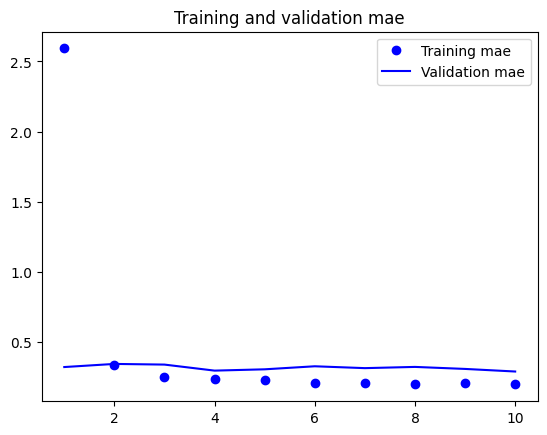

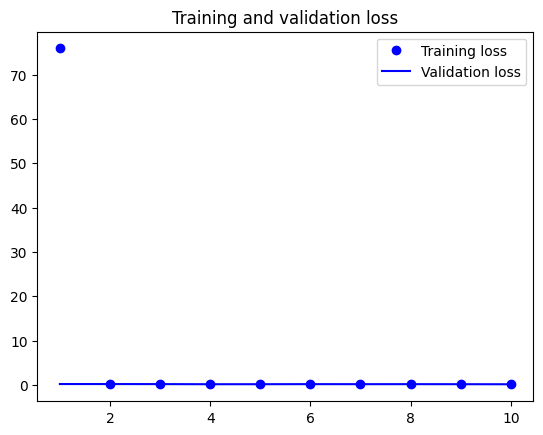

In [28]:
plot_loss(history)

In [29]:
# 评估模型性能
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

5/5 [==============================] - 0s 31ms/step - loss: 0.1385 - mae: 0.2887
Test Loss: 0.1385274976491928, Test MAE: 0.2887333333492279
